# CF preprocessing with new modules
In this notebook I use participant class to get my data preprocessed and then I use the visual space and limit vertices functionality I added to prfpy for CF analysis.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy.optimize import curve_fit

import cortex as cx

from prfpy.stimulus import PRFStimulus2D
from prfpy.utils import Subsurface

from scipy.io import loadmat
from scipy.ndimage import median_filter, gaussian_filter, binary_propagation

from cftools.preprocess import split_given_size, get_cortex

In [3]:
def angle(x0, y0):
    return np.angle(x0 + y0 * 1j)

def ecc(x0, y0):
    return np.abs(x0 + y0 * 1j)

def splitList(array):
    n = len(array)
    half = int(n/2) # py3
    return array[:half], array[n-half:]

### CF analysis

In [4]:
# load design matrix of pRF experiment. We use this to determine max eccentricity

dms = loadmat('/scratch/2021/nprf_ss/derivatives/vis_design.mat')['stim'].T

# we have to do a bit of processing on the design matrix. 
# in essence this is a very slowly sampled movie of where the stimulus was on the screen
# you have one frame per TR, so that the analysis becomes easier. 

pixel_offset = int((dms.shape[1] - dms.shape[2]) / 2)
new_dms = np.zeros((dms.shape[0], dms.shape[1], dms.shape[1]))
for timepoint in range(dms.shape[0]):
    square_screen = np.zeros_like(new_dms[timepoint])
    square_screen[:,pixel_offset:pixel_offset+dms.shape[2]] = (dms[timepoint]!=0).astype(float)
    new_dms[timepoint,:,] = gaussian_filter(square_screen, 10).T

# if we then re-sample this design matrix to the same 100 x 100
# pixel space of our models above, our model space and stimulus space align. 

new_dms = new_dms[:,::5,::5]

prf_stim = PRFStimulus2D(screen_size_cm=69, 
                         screen_distance_cm=220, 
                         design_matrix=new_dms.T, 
                         TR=1.5)

grid_nr = 20
max_ecc_size = prf_stim.screen_size_degrees/2.0
sizes, eccs, polars = max_ecc_size * np.linspace(0.25, 1, grid_nr)**2, \
    max_ecc_size * np.linspace(0.1, 1, grid_nr)**2, \
    np.linspace(0, 2*np.pi, grid_nr)

print(max_ecc_size)

8.912434969522739


In [5]:
# load fits
sub = 'sub-02'

prf_gauss = np.load(f'/tank/shared/2021/visual/DN-CF/derivatives/fits_weighted/pRF-params_{sub}_gauss_weighted.npy')
prf_dn = np.load(f'/tank/shared/2021/visual/DN-CF/derivatives/fits_weighted/pRF-params_{sub}_norm_weighted.npy')

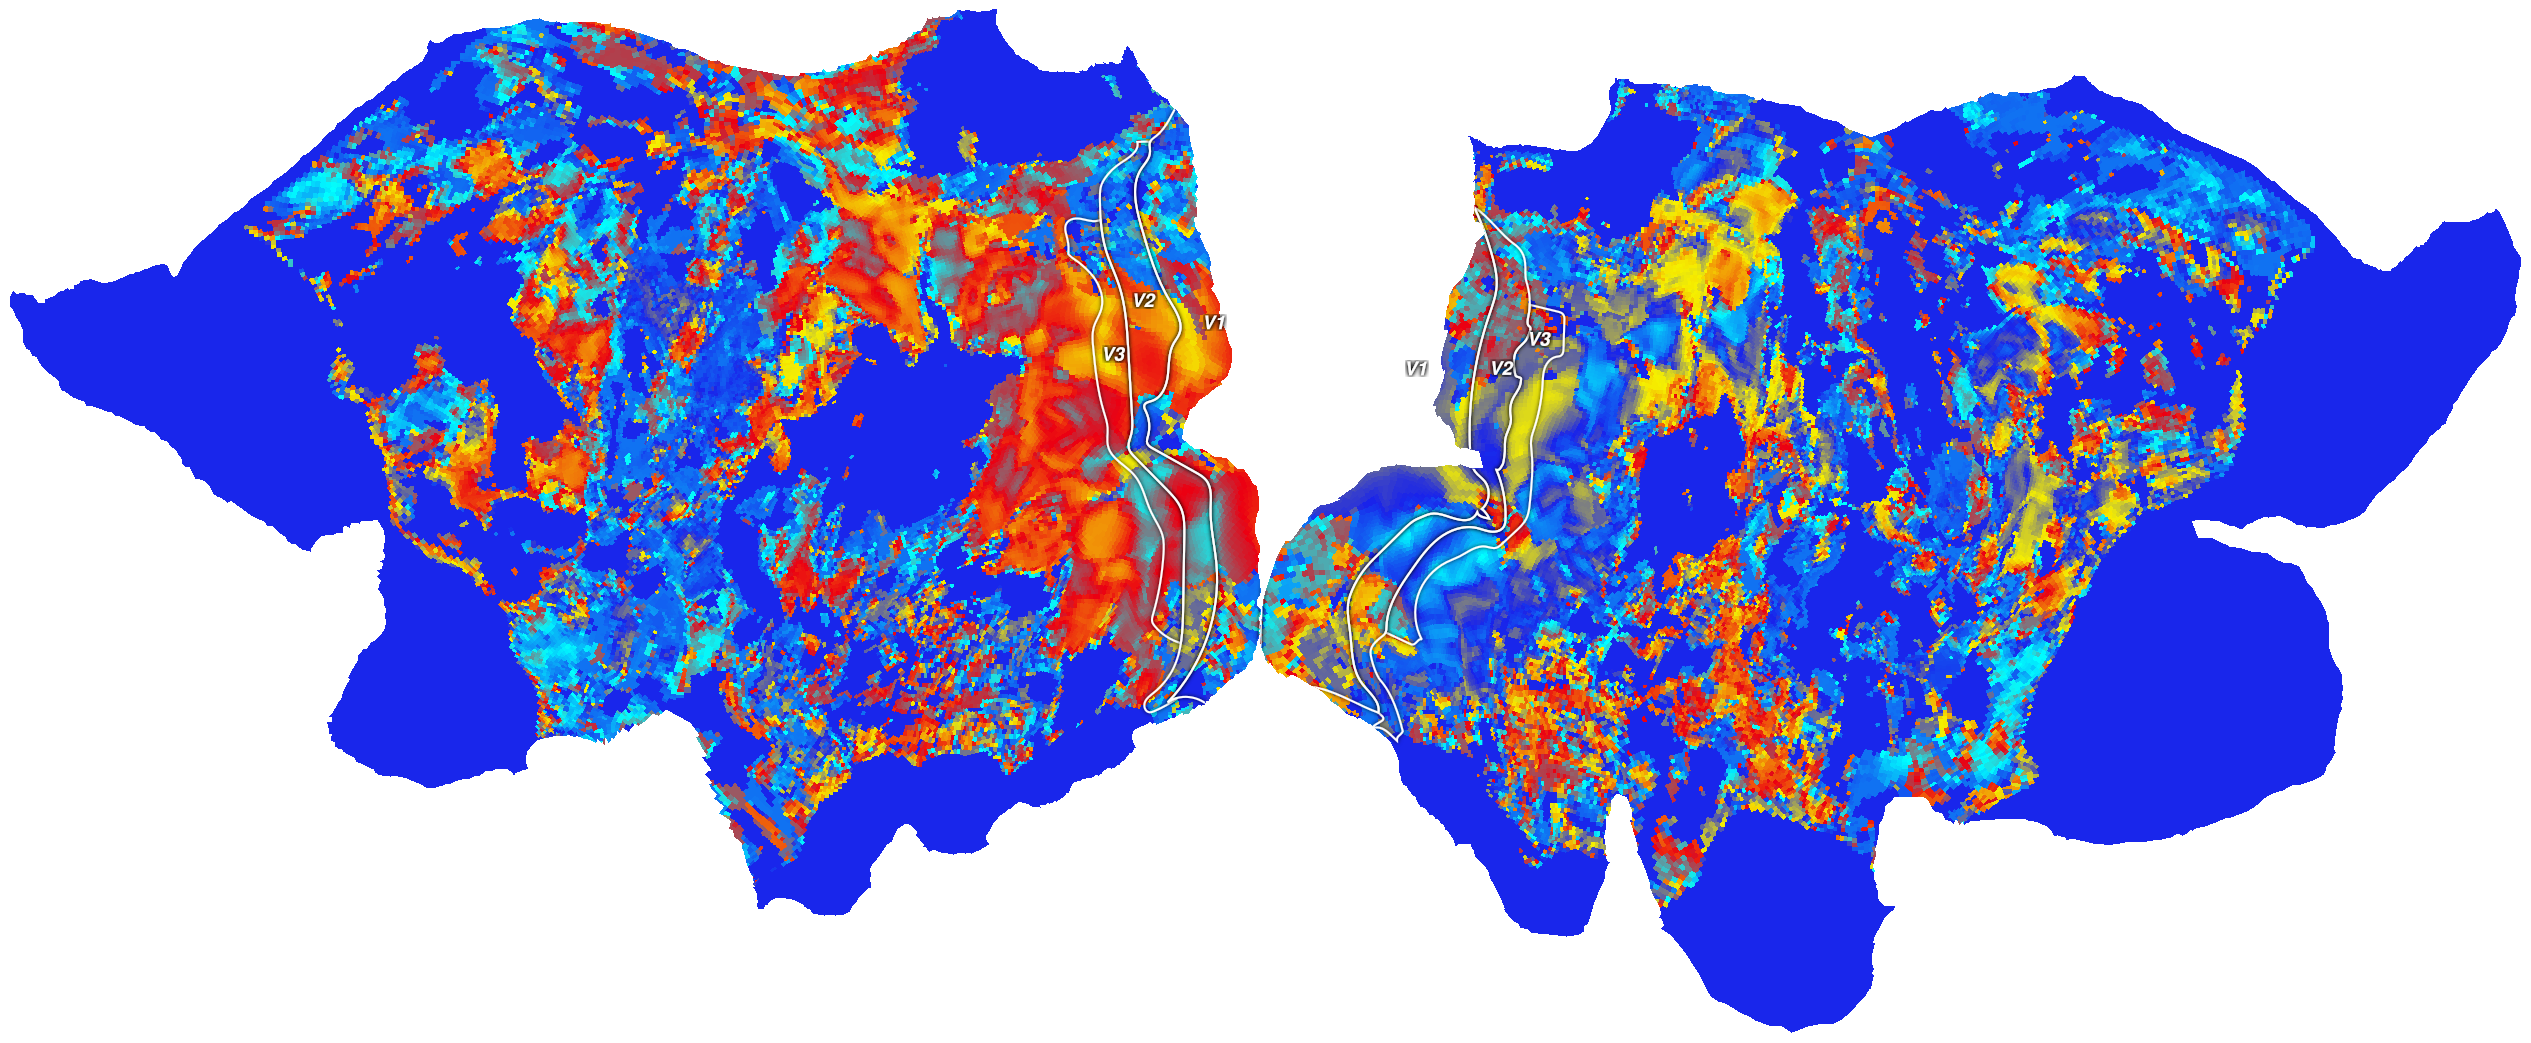

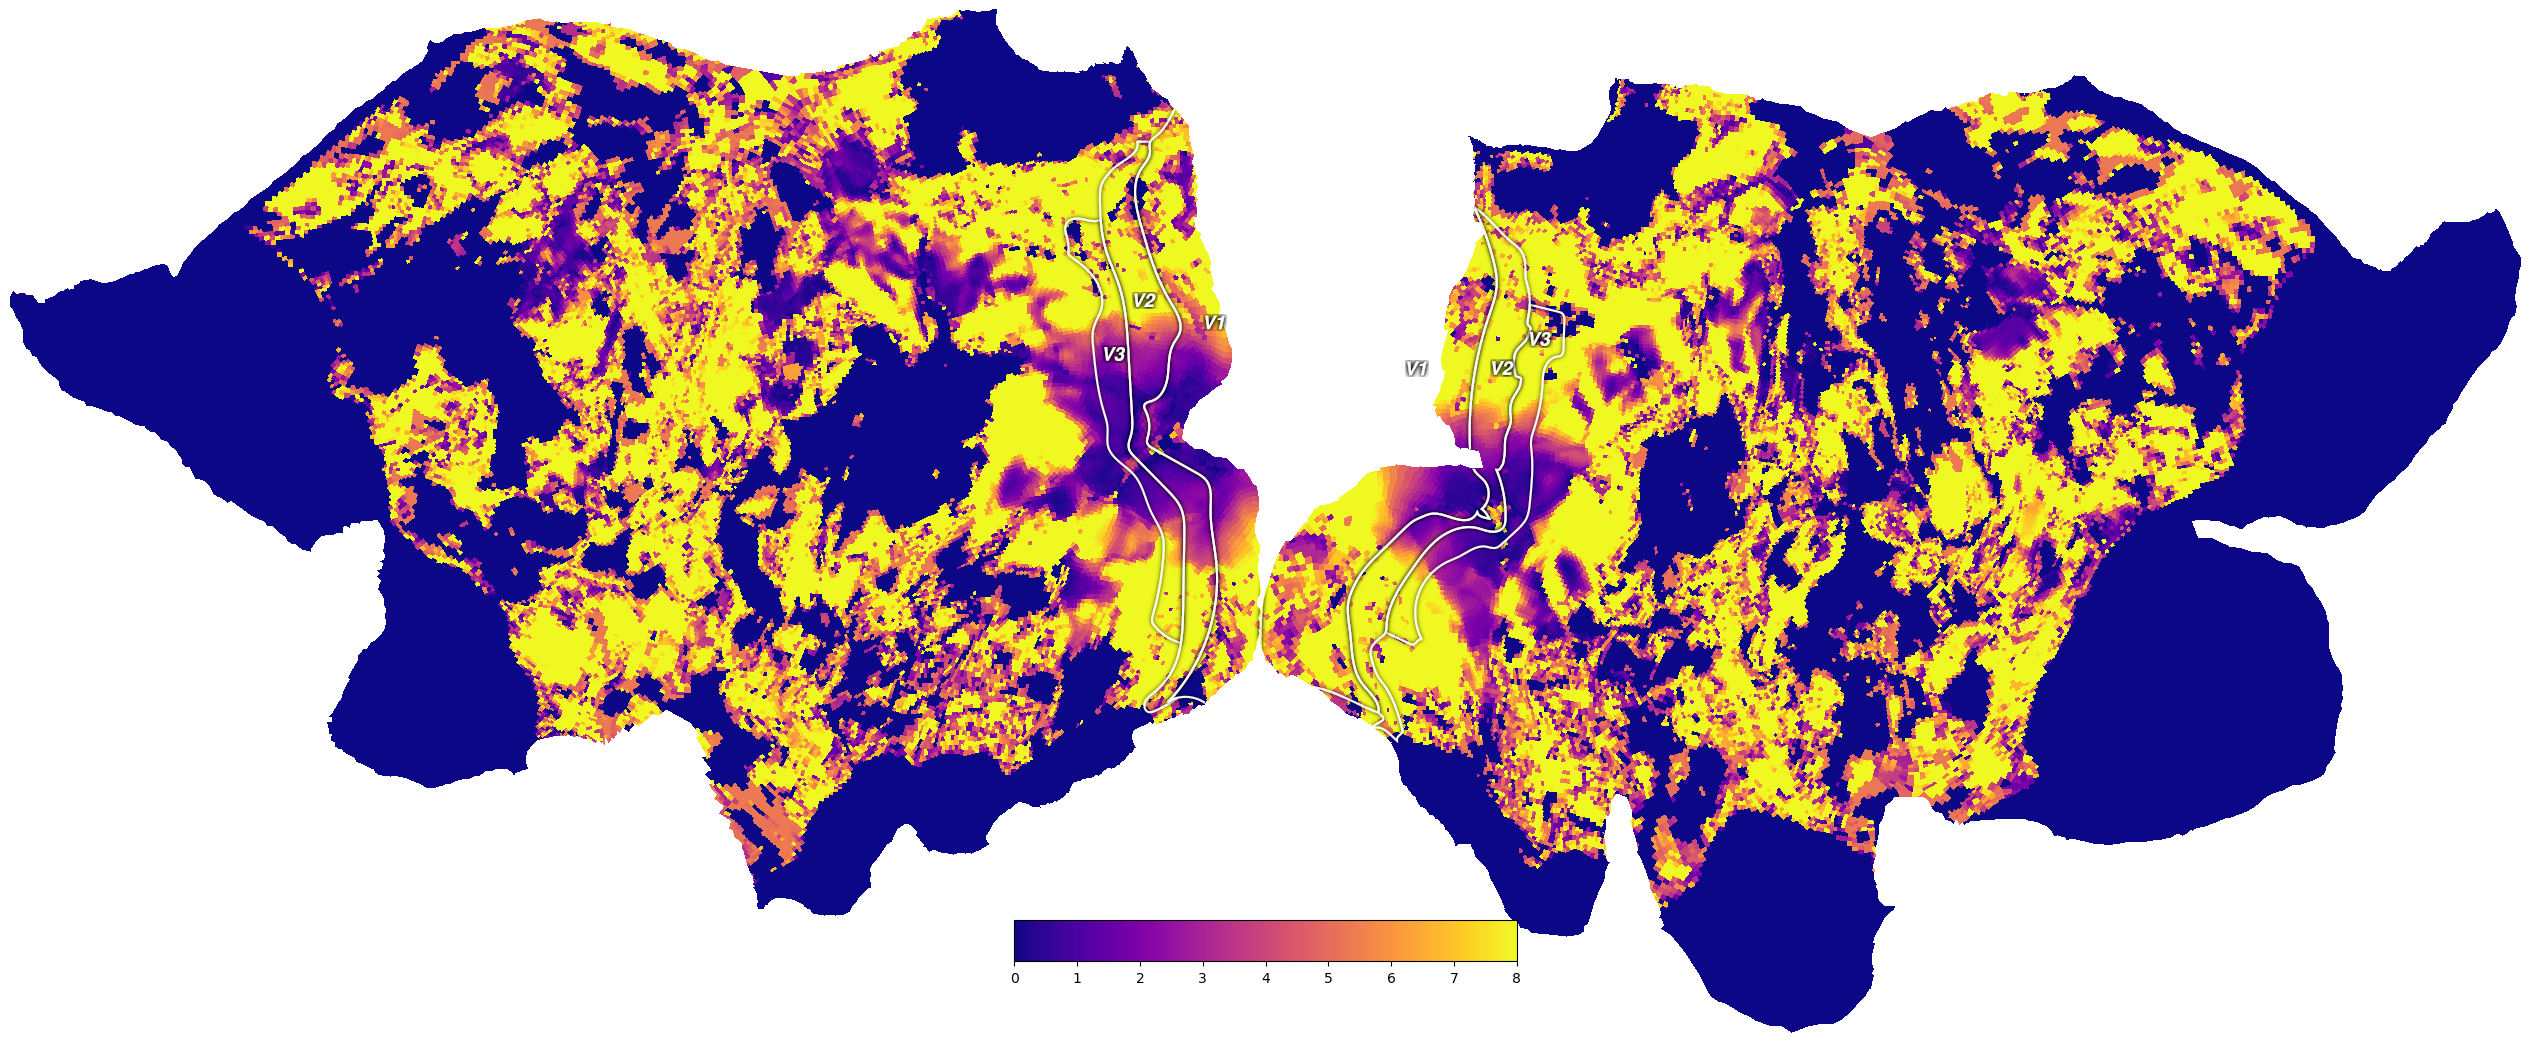

In [6]:
# visual inspection of params for sanity check

toplot = np.zeros([118584,])
toplot[:] = np.nan
toplot = get_cortex(angle(prf_gauss[:,1], prf_gauss[:,0]*-1))
cx.quickshow(cx.Vertex(toplot, subject='hcp_999999', cmap='Retinotopy_RYBCR', vmin=-np.pi, vmax=np.pi), with_curvature=True, with_colorbar=False);


toplot = np.zeros([118584,])
toplot[:] = np.nan
toplot = get_cortex(ecc(prf_gauss[:,1], prf_gauss[:,0]*-1))
cx.quickshow(cx.Vertex(toplot, subject='hcp_999999', cmap='plasma', vmin=0, vmax=8), with_curvature=True, with_colorbar=True);


In [7]:
# def load_wang(space, wcard='{hem}.wang_{space}.label.gii',wangloc='/tank/klundert/fsphere/'):
#     ldat,rdat=nib.load(os.path.join(wangloc,wcard.format(hem='L',space=space))),nib.load(os.path.join(wangloc,wcard.format(hem='R',space=space)))
#     fulldat=np.concatenate([ldat.agg_data(),rdat.agg_data()])
#     return fulldat

# atlas_data = load_wang('HCP')

# roi_index_dict = {
#     'V1':  [1,  2], 'V2':  [3, 4], 'V3':  [5, 6], 'V3AB':  [16, 17], 'hV4':  7, 'VO':  [8, 9], 'PHC':  [10, 11],
#     'TO':  [12, 13], 'LO':  [14, 15], 'IPS':  [18, 19, 20, 21, 22, 23], 'SPL1':  24, 'FEF': 25}


# roimask = np.isin(atlas_data, roi_index_dict['V2'])
# for l, ROI in enumerate(list(roi_index_dict)[1:]):
#     roimask = np.isin(atlas_data, roi_index_dict[ROI]) + roimask
    
# V3mask = np.isin(atlas_data, roi_index_dict['V3'])

### visually inspect the CFM curve fit that is used for creating the log visual space design matrix
### further down the notebook will plot which vertices it will include for all design matrices as well
### visually inspec these 

Generating subsurfaces
Discarding 1 vertices from the left hemisphere
Discarding 0 vertices from the right hemisphere
Creating distance by distance matrices


/tank/klundert/downloads/cfpy/prfpy/utils.py:71: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self.subsurface_verts_L = np.where(self.subsurface_L.subsurface_vertex_map != stats.mode(
/tank/klundert/downloads/cfpy/prfpy/utils.py:73: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid 

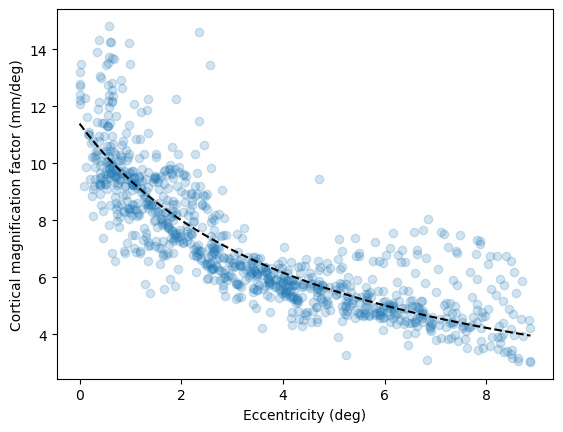

Cortical magnification factor parameters: 
lambda =  53.73198585746644
ecc0 =  4.717342151296012


In [10]:
# I load some older fits here as these are the ones I used for my current CF analysis, before writing
# the format.py code, which automatically formats the fits and stores them in shared

sub = 1
prf_gauss = np.load(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/pRF_fits/pRF-params_sub-0{sub}_gauss.npy')
prf_dn = np.load(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/pRF_fits/pRF-params_sub-0{sub}_norm.npy')


# get the V1 verts specific for this subject
roi_verts = cx.get_roi_verts(f'hcp_999999_sub-0{sub}', f's{sub}_V1', mask=True)


ROI = f's{sub}_V1'

maskL=roi_verts[ROI][:59292]
maskR=roi_verts[ROI][59292:]

# this is to get indices for everything outside of V1, for fitting purpose
brainmask = ~roi_verts[f's{sub}_V1']

# myv1surf=Subsurface(f'hcp_999999_sub-0{sub}',[maskL,maskR]) # surf = fiducial, inflated, veryinflated, 
# hyperinflated, superinflated, flat, sphere

myv1surf=Subsurface(f'hcp_999999',[maskL,maskR]) # surf = fiducial, inflated, veryinflated, 
myv1surf.create()


# assign prf paramaters for creating visual space distance matrix and limiting the vertices
prf_params = get_cortex(prf_gauss)
gfn_ecc = ecc(prf_params[:,0], prf_params[:,1])
gfn_rsq = prf_params[:,-1]

# maxrsq set to -1 as I want to only exclude vertices based on eccentricity for now
myv1surf.limit_vertices(gfn_ecc, gfn_rsq, max_ecc_size, maxrsq = -1)
myv1surf.create_visual_space(prf_params[:,0], prf_params[:,1])

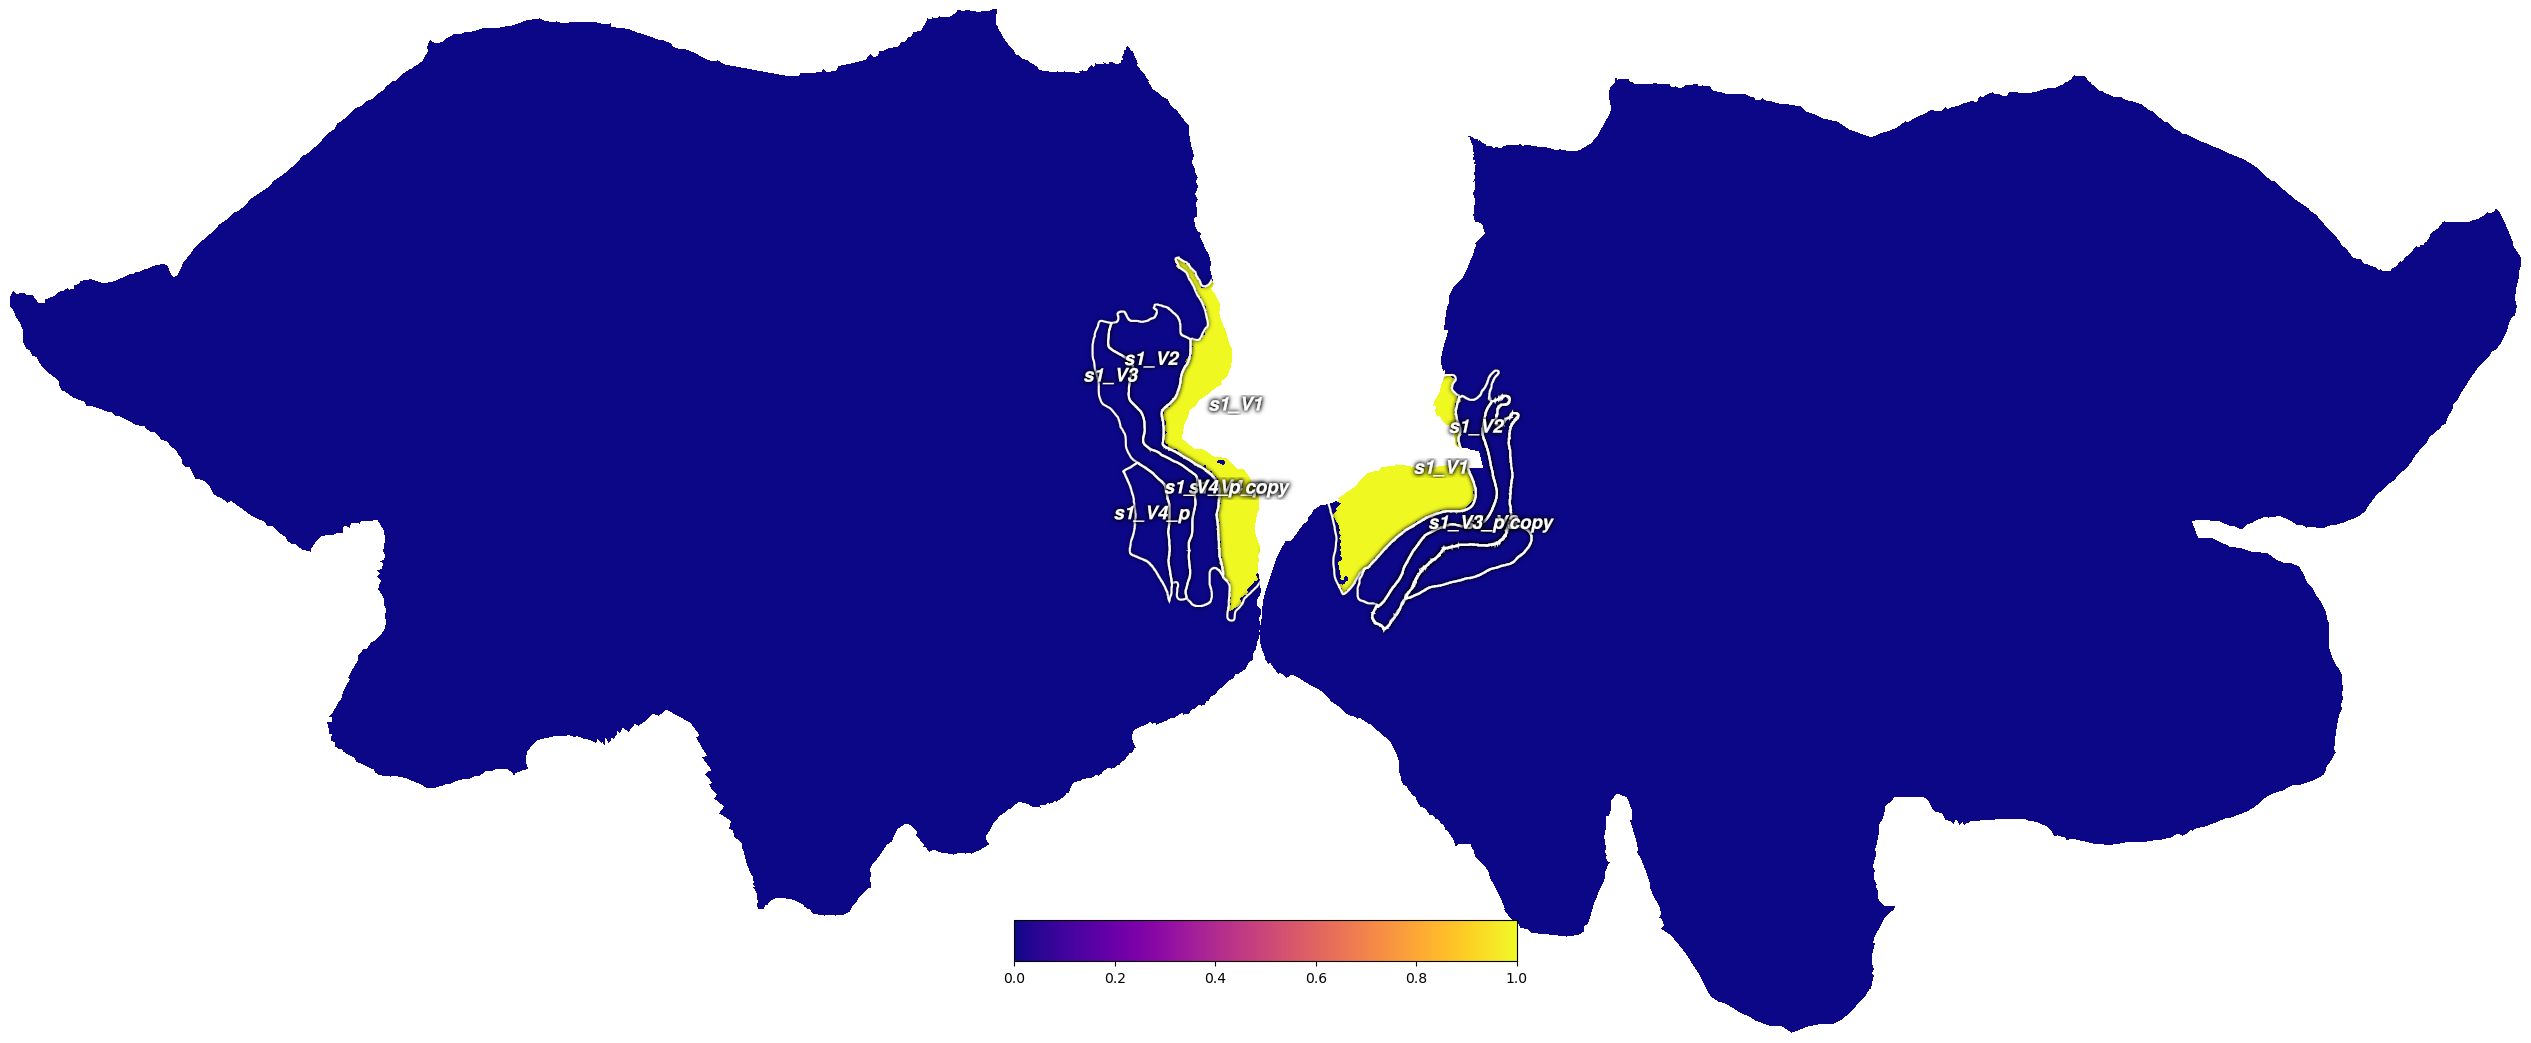

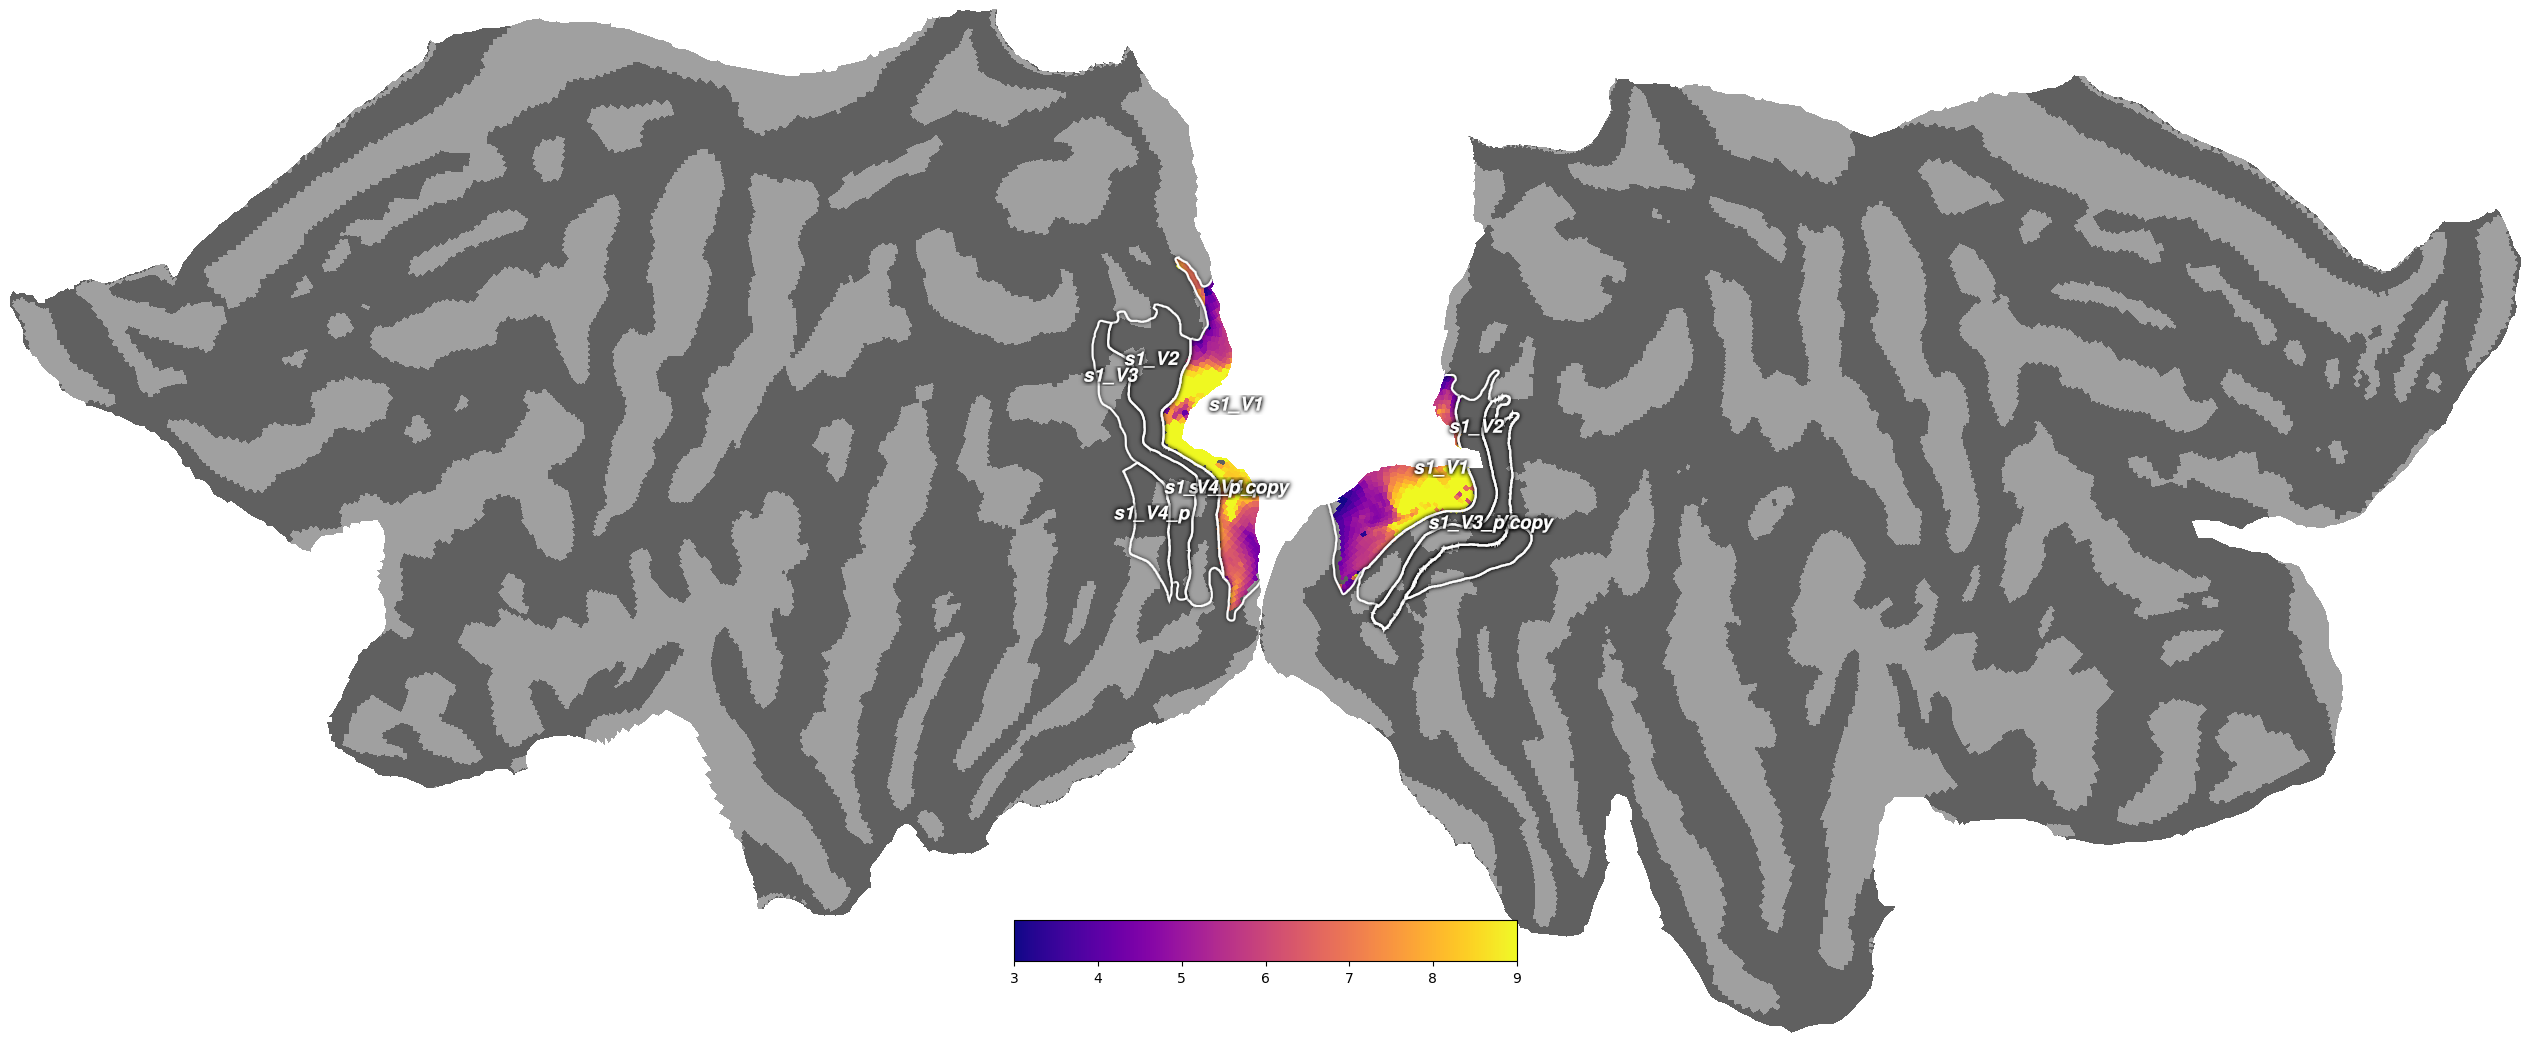

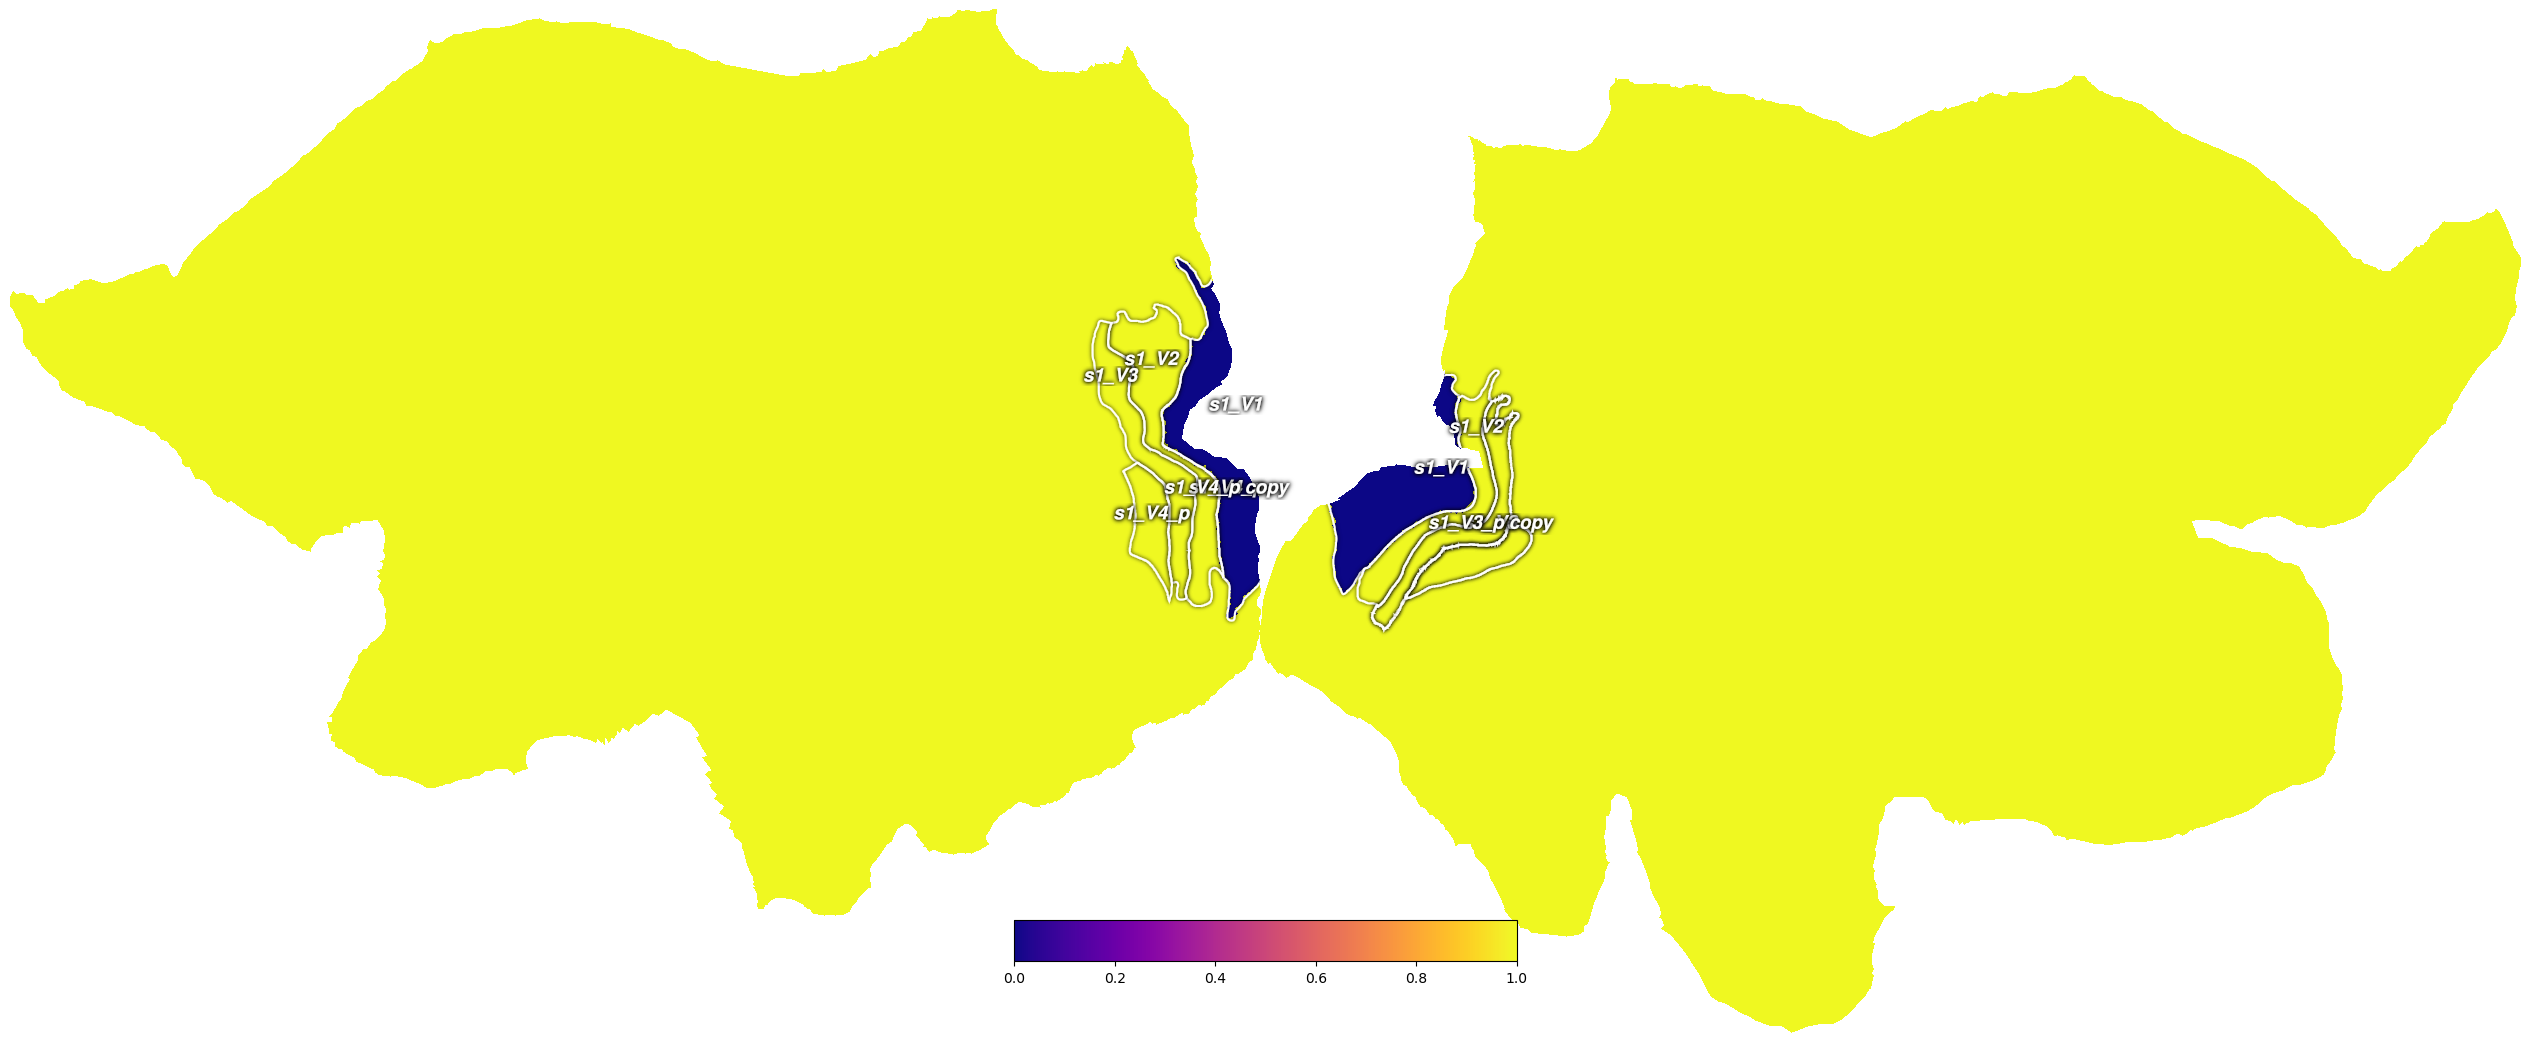

In [11]:
# following plots will show
# 1: vertices used for CF design matrix
# 2: CMF plotted for V1
# 3: the mask we can use for CF fitting

v1mask = myv1surf.intmask.astype(bool)

toplot = np.zeros([myv1surf.intmask.size])
toplot[:] = np.nan
toplot[v1mask] = myv1surf.CMF

cx.quickshow(cx.Vertex(myv1surf.intmask, subject=f'hcp_999999_sub-0{sub}', cmap='plasma', vmin=0, vmax=1), with_curvature=True);
cx.quickshow(cx.Vertex(toplot, subject=f'hcp_999999_sub-0{sub}', cmap='plasma', vmin=3, vmax=9), with_curvature=True);
cx.quickshow(cx.Vertex(brainmask.astype(int), subject=f'hcp_999999_sub-0{sub}', cmap='plasma', vmin=0, vmax=1), with_curvature=True);


In [202]:
# save these files to a folder that I will transfer to LISA for fitting
# /tank/shared/2021/visual/DN-CF/CF_fit_utils/ as these files are also used later for viz.py


np.save(f'/tank/shared/2021/visual/DN-CF/CF_fit_utils/distance_matrix_sub-0{sub}_hcp_NoR2.npy', myv1surf.distance_matrix)
np.save(f'/tank/shared/2021/visual/DN-CF/CF_fit_utils/subsurface_verts_sub-0{sub}_hcp_NoR2.npy', myv1surf.subsurface_verts)

np.save(f'/tank/shared/2021/visual/DN-CF/CF_fit_utils/visual_distance_matrix_sub-0{sub}_hcp_NoR2.npy', myv1surf.visual_distance_matrix)
np.save(f'/tank/shared/2021/visual/DN-CF/CF_fit_utils/logvisual_distance_matrix_sub-0{sub}_hcp_NoR2.npy', myv1surf.logvisual_distance_matrix)
np.save(f'/tank/shared/2021/visual/DN-CF/CF_fit_utils/brainmask_sub-0{sub}_NoR2.npy', brainmask)





In [12]:


np.save(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/distance_matrix_sub-0{sub}_hcp_NoR2.npy', myv1surf.distance_matrix)
np.save(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/subsurface_verts_sub-0{sub}_hcp_NoR2.npy', myv1surf.subsurface_verts)

np.save(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/visual_distance_matrix_sub-0{sub}_hcp_NoR2.npy', myv1surf.visual_distance_matrix)
np.save(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/logvisual_distance_matrix_sub-0{sub}_hcp_NoR2.npy', myv1surf.logvisual_distance_matrix)
np.save(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/brainmask_sub-0{sub}_NoR2.npy', brainmask)

## more experimental stuff down here:
I experiment with how the curve is fitted

In [23]:
def magnification(x, a, b):
    """magnification
        Function used to fit cortical magnification factor parameters
    """
    return a/(b+x)

[38.68477001  1.33834961]


Text(0, 0.5, 'Cortical magnification factor (mm/deg)')

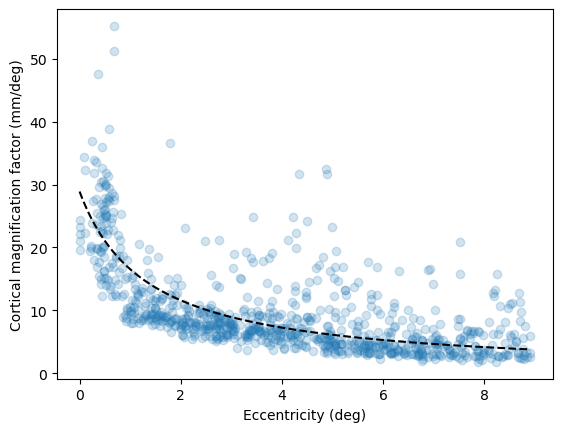

In [24]:
# here I calculate the CMF based on binned eccentricity, where I calculate the
# CMF based on the average distance between vertices in mm cortex per visual degree, 
# within the binened eccentricity range. i.e. 

myv1surf.CMF_matrix.shape

tmask = myv1surf.tofit_x < 1

tmask1 = (myv1surf.tofit_x >= 1) * (myv1surf.tofit_x < 2)
tmask2 = (myv1surf.tofit_x >= 2) * (myv1surf.tofit_x < 3)
tmask3 = (myv1surf.tofit_x >= 3) * (myv1surf.tofit_x < 4)
tmask4 = (myv1surf.tofit_x >= 4) * (myv1surf.tofit_x < 5)
tmask5 = (myv1surf.tofit_x >= 5) * (myv1surf.tofit_x < max_ecc_size)


# ((tofit_x >= 1) * (tofit_x < 2)).sum()

myv1surf.CMF_matrix

fmask = np.ix_(tmask, tmask)
fmask1 = np.ix_(tmask1, tmask1)
fmask2 = np.ix_(tmask2, tmask2)
fmask3 = np.ix_(tmask3, tmask3)
fmask4 = np.ix_(tmask4, tmask4)
fmask5 = np.ix_(tmask5, tmask5)

a=np.nanmean(myv1surf.CMF_matrix[fmask], axis=1)
b=np.nanmean(myv1surf.CMF_matrix[fmask1], axis=1)
c=np.nanmean(myv1surf.CMF_matrix[fmask2], axis=1)
d=np.nanmean(myv1surf.CMF_matrix[fmask3], axis=1)
e=np.nanmean(myv1surf.CMF_matrix[fmask4], axis=1)
f=np.nanmean(myv1surf.CMF_matrix[fmask5], axis=1)



x = np.concatenate((myv1surf.tofit_x[tmask], myv1surf.tofit_x[tmask1], myv1surf.tofit_x[tmask2], myv1surf.tofit_x[tmask3], myv1surf.tofit_x[tmask4], myv1surf.tofit_x[tmask5]))

y = np.concatenate((a,b,c,d,e,f))



tofit_x = x
tofit_y = y

myv1surf.CMF_matrix

pars, cov = curve_fit(f=magnification, xdata=tofit_x, 
              ydata=tofit_y, p0=[40, 6], method='trf')



# pars = [20.14400586, 0.7611809]

# extract the parameters
lamb, ecc0 = pars

# pars = [50, 4]
print(pars)


plotx = np.linspace(start=np.nanmin(tofit_x), stop=np.nanmax(tofit_x), num=200)
fig, ax = plt.subplots()
ax.scatter(tofit_x, tofit_y, alpha=0.2)
ax.plot(plotx, magnification(plotx, *pars), linestyle='--', color='black')
ax.set_xlabel('Eccentricity (deg)')
ax.set_ylabel('Cortical magnification factor (mm/deg)')

In [25]:
from scipy import stats

bins = stats.binned_statistic(myv1surf.tofit_x, myv1surf.tofit_y, 'median', bins=100)

# plt.plot(bins[1], bins[0])
newbins = []
for i in range(100):
    newbins.append(np.mean([bins[1][0+i], bins[1][1+i]]))
bins[0]

array([10.57939094,  9.24750049, 10.30094421,  9.3183771 ,  8.76844717,
        9.16266469, 10.07396795,  9.87872667,  9.04293218,  7.89936907,
        8.08124653,  6.80851022,  6.27161388,  6.97890413,  7.01588022,
        6.57430162,  6.30444127,  6.70881256,  7.31623722,  7.07016818,
        7.44593765,  7.74738469,  5.90905422,  6.45091283,  6.38915908,
        6.42512422,  5.57591898,  5.64156873,  5.56011347,  6.61937191,
        5.89836725,  5.79214488,  5.30662776,  5.9650078 ,  5.2611535 ,
        5.40943721,  6.87756701,  5.12096035,  5.73170028,  5.6319341 ,
        5.37756289,  4.96082726,  5.65693747,  4.99137153,  4.81524844,
        5.10007701,  5.38487173,  6.40522128,  4.67185984,  4.63279432,
        4.97587466,  4.8953511 ,  7.06757089,  5.4718192 ,  4.77358407,
        4.47282986,  4.74400941,  4.6379127 ,  6.33320446,  4.24616717,
        5.47794196,  5.1008926 ,  3.77329782,  4.84926806,  3.89561172,
        4.39078186,  4.44614967,  4.14793525,  4.5751309 ,  4.65

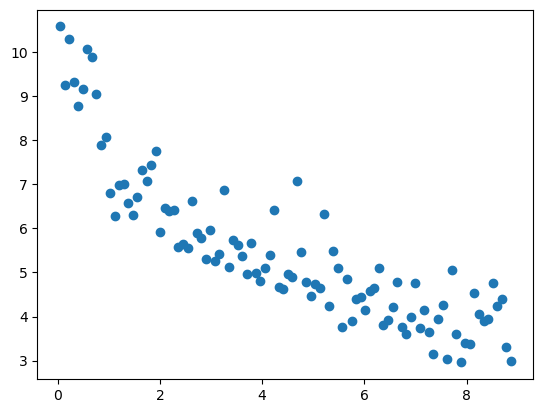

In [26]:
np.array(newbins).shape

plt.scatter(np.array(newbins), bins[0])


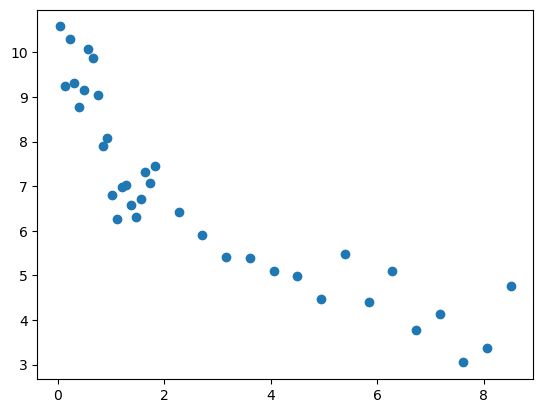

In [27]:
# plt.scatter(np.array(newbins), bins[0])


plt.scatter(np.hstack([np.array(newbins)[:20], np.array(newbins)[20::5]]), np.hstack([bins[0][:20], bins[0][20::5]]))

In [28]:
myv1surf.CMF_matrix.shape

tmask = myv1surf.tofit_x < 1

tmask1 = (myv1surf.tofit_x >= 1) * (myv1surf.tofit_x < 2)
tmask2 = (myv1surf.tofit_x >= 2) * (myv1surf.tofit_x < 3)
tmask3 = (myv1surf.tofit_x >= 3) * (myv1surf.tofit_x < 4)
tmask4 = (myv1surf.tofit_x >= 4) * (myv1surf.tofit_x < 5)
tmask5 = (myv1surf.tofit_x >= 5) * (myv1surf.tofit_x < max_ecc_size)


# ((tofit_x >= 1) * (tofit_x < 2)).sum()

myv1surf.CMF_matrix

fmask = np.ix_(tmask, tmask)
fmask1 = np.ix_(tmask1, tmask1)
fmask2 = np.ix_(tmask2, tmask2)
fmask3 = np.ix_(tmask3, tmask3)
fmask4 = np.ix_(tmask4, tmask4)
fmask5 = np.ix_(tmask5, tmask5)




myv1surf.CMF_matrix[fmask].shape



(117, 117)

In [29]:
a=np.nanmean(myv1surf.CMF_matrix[fmask], axis=1)
b=np.nanmean(myv1surf.CMF_matrix[fmask1], axis=1)
c=np.nanmean(myv1surf.CMF_matrix[fmask2], axis=1)
d=np.nanmean(myv1surf.CMF_matrix[fmask3], axis=1)
e=np.nanmean(myv1surf.CMF_matrix[fmask4], axis=1)
f=np.nanmean(myv1surf.CMF_matrix[fmask5], axis=1)



x = np.concatenate((myv1surf.tofit_x[tmask], myv1surf.tofit_x[tmask1], myv1surf.tofit_x[tmask2], myv1surf.tofit_x[tmask3], myv1surf.tofit_x[tmask4], myv1surf.tofit_x[tmask5]))

y = np.concatenate((a,b,c,d,e,f))






[38.68477001  1.33834961]


Text(0, 0.5, 'Cortical magnification factor (mm/deg)')

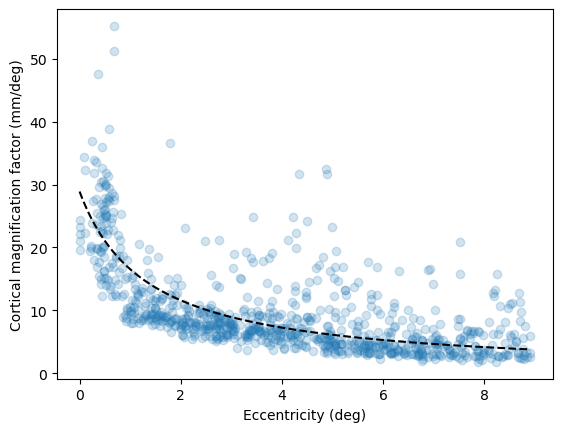

In [30]:
incl = 20 # all fist X values
incl_step = 10 # then include every i-th value

tofit_x = np.hstack([np.array(newbins)[:incl], np.array(newbins)[incl::incl_step]])
tofit_y = np.hstack([bins[0][:incl], bins[0][incl::incl_step]])

# tofit_x = myv1surf.tofit_x[myv1surf.tofit_y < 9]
# tofit_y = myv1surf.tofit_y[myv1surf.tofit_y < 9]


tofit_x = myv1surf.tofit_x[tmask]
# tofit_y = myv1surf.tofit_y
tofit_y = np.nanmean(myv1surf.CMF_matrix[fmask], axis=1)

tofit_x = x
tofit_y = y

myv1surf.CMF_matrix

pars, cov = curve_fit(f=magnification, xdata=tofit_x, 
              ydata=tofit_y, p0=[40, 6], method='trf')



# pars = [20.14400586, 0.7611809]

# extract the parameters
lamb, ecc0 = pars

# pars = [50, 4]
print(pars)


plotx = np.linspace(start=np.nanmin(tofit_x), stop=np.nanmax(tofit_x), num=200)
fig, ax = plt.subplots()
ax.scatter(tofit_x, tofit_y, alpha=0.2)
ax.plot(plotx, magnification(plotx, *pars), linestyle='--', color='black')
ax.set_xlabel('Eccentricity (deg)')
ax.set_ylabel('Cortical magnification factor (mm/deg)')

Generating subsurfaces
Creating distance by distance matrices


/tank/klundert/downloads/cfpy/prfpy/utils.py:71: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self.subsurface_verts_L = np.where(self.subsurface_L.subsurface_vertex_map != stats.mode(
/tank/klundert/downloads/cfpy/prfpy/utils.py:73: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid 

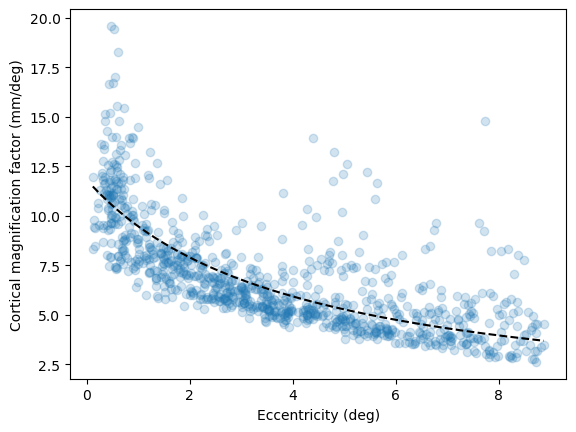

Cortical magnification factor parameters: 
lambda =  47.620485721934976
ecc0 =  4.029060737580369


In [31]:
# V1 based on old fits

sub = 2
fold = 1

roi_verts = cx.get_roi_verts('hcp_999999', 'V1',mask=True)

maskL=roi_verts['V1'][:59292]
maskR=roi_verts['V1'][59292:]

myv1surf=Subsurface('hcp_999999',[maskL,maskR]) # surf = fiducial, inflated, veryinflated, 
# hyperinflated, superinflated, flat, sphere

myv1surf.create()


# load prf paramaters for creating visual space distance matrix and limiting the vertices
prf_params = get_cortex(np.load(f'/scratch/2021/nprf_ss/derivatives/prf-fits/sub-0{sub}/dn-prf/sub-0{sub}_task-prf_space-fsLR_den-170k_desc-preproc_normPRF_params_cv_fold{fold}.npy'))
gfn_ecc = ecc(prf_params[:,0], prf_params[:,1])
gfn_rsq = prf_params[:,-1]

myv1surf.limit_vertices(gfn_ecc, gfn_rsq, max_ecc_size, maxrsq = 0.4)
myv1surf.create_visual_space(prf_params[:,0], prf_params[:,1])

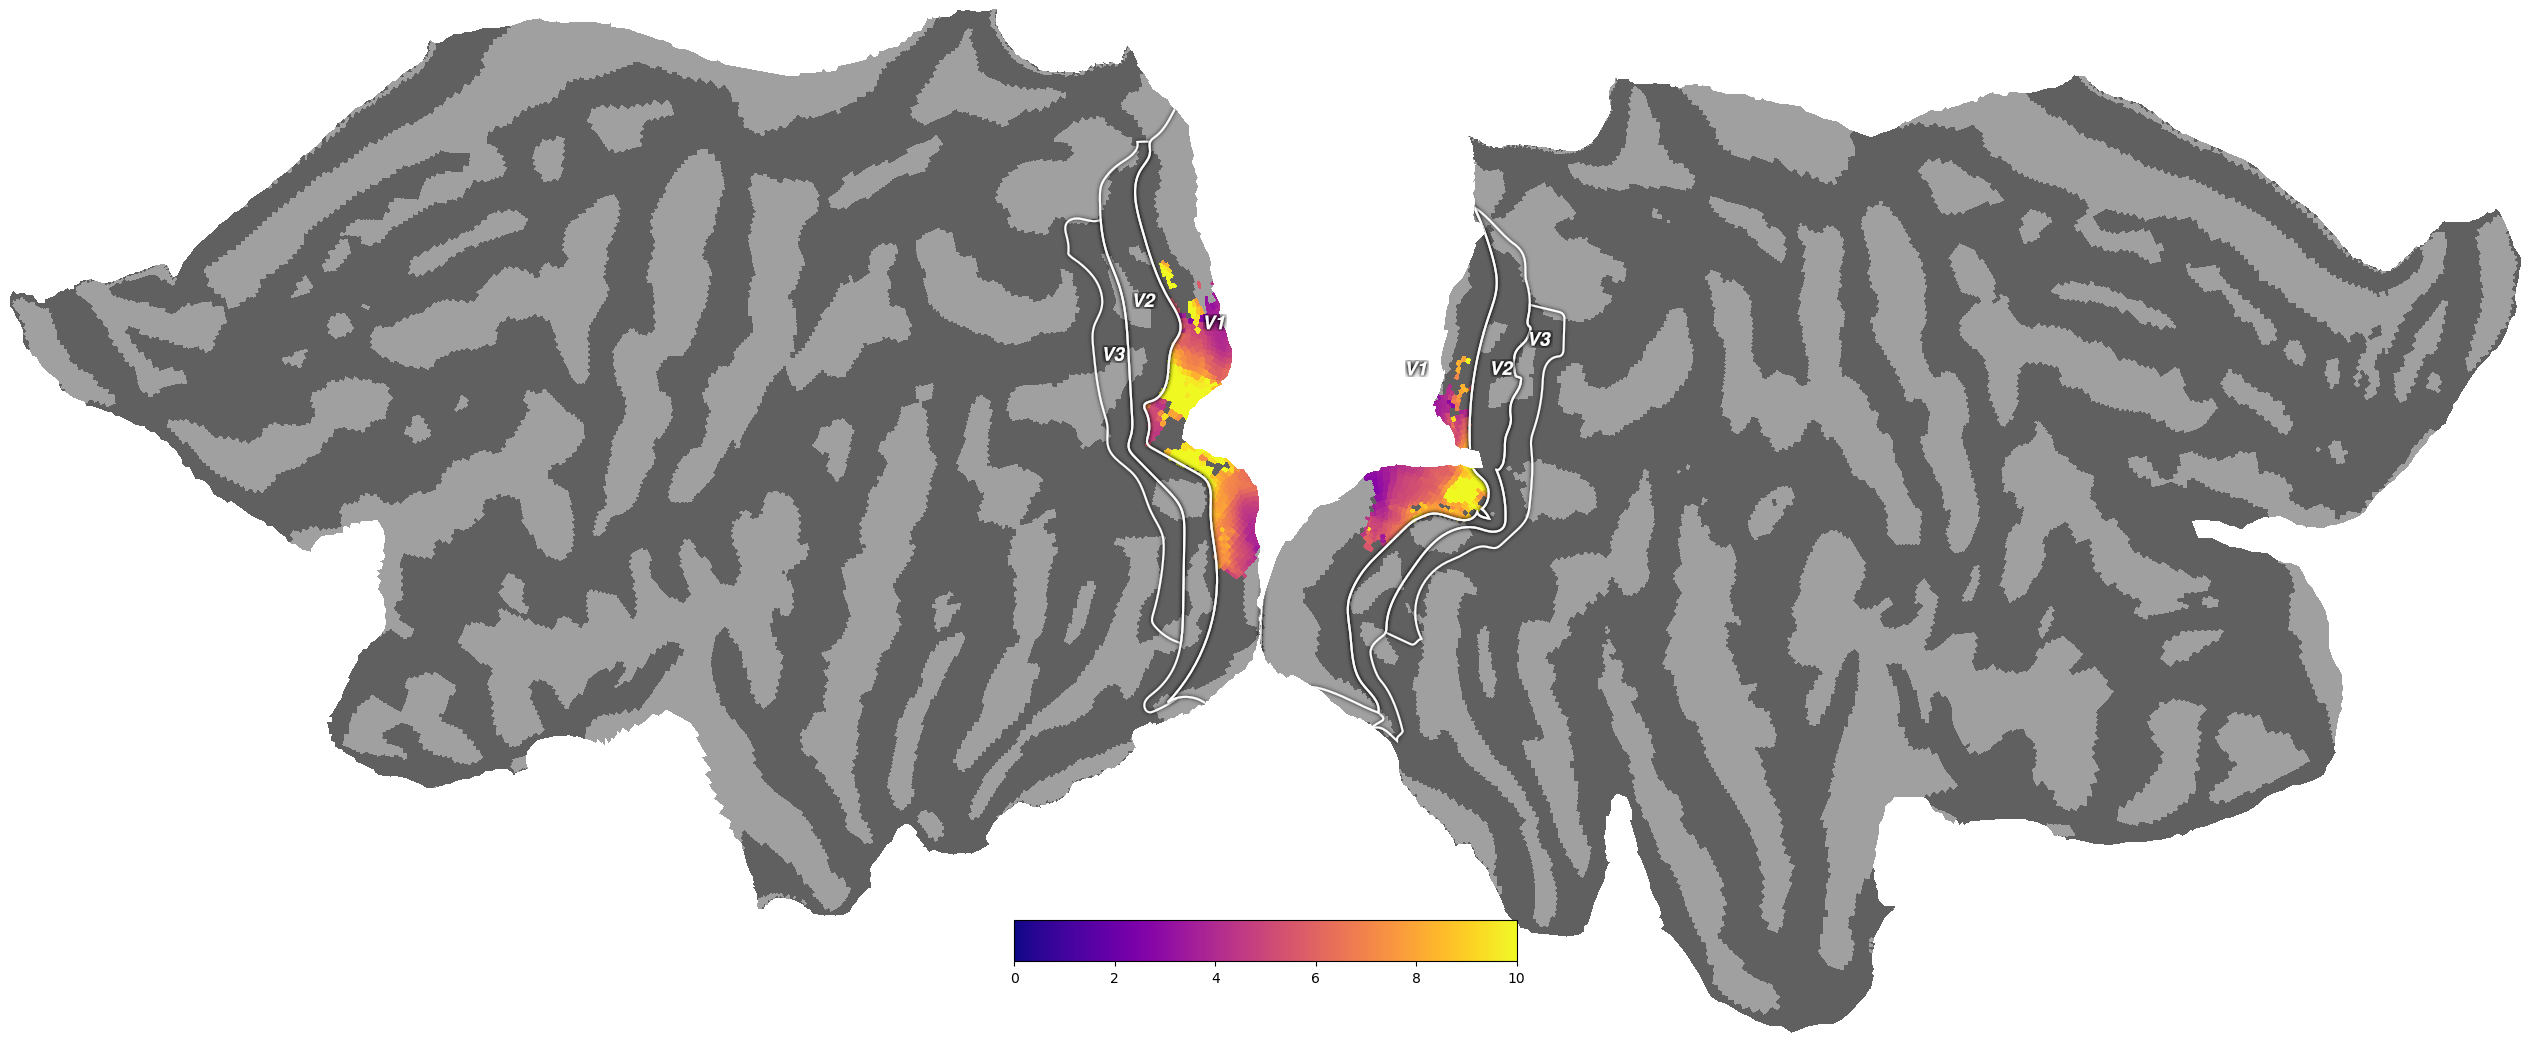

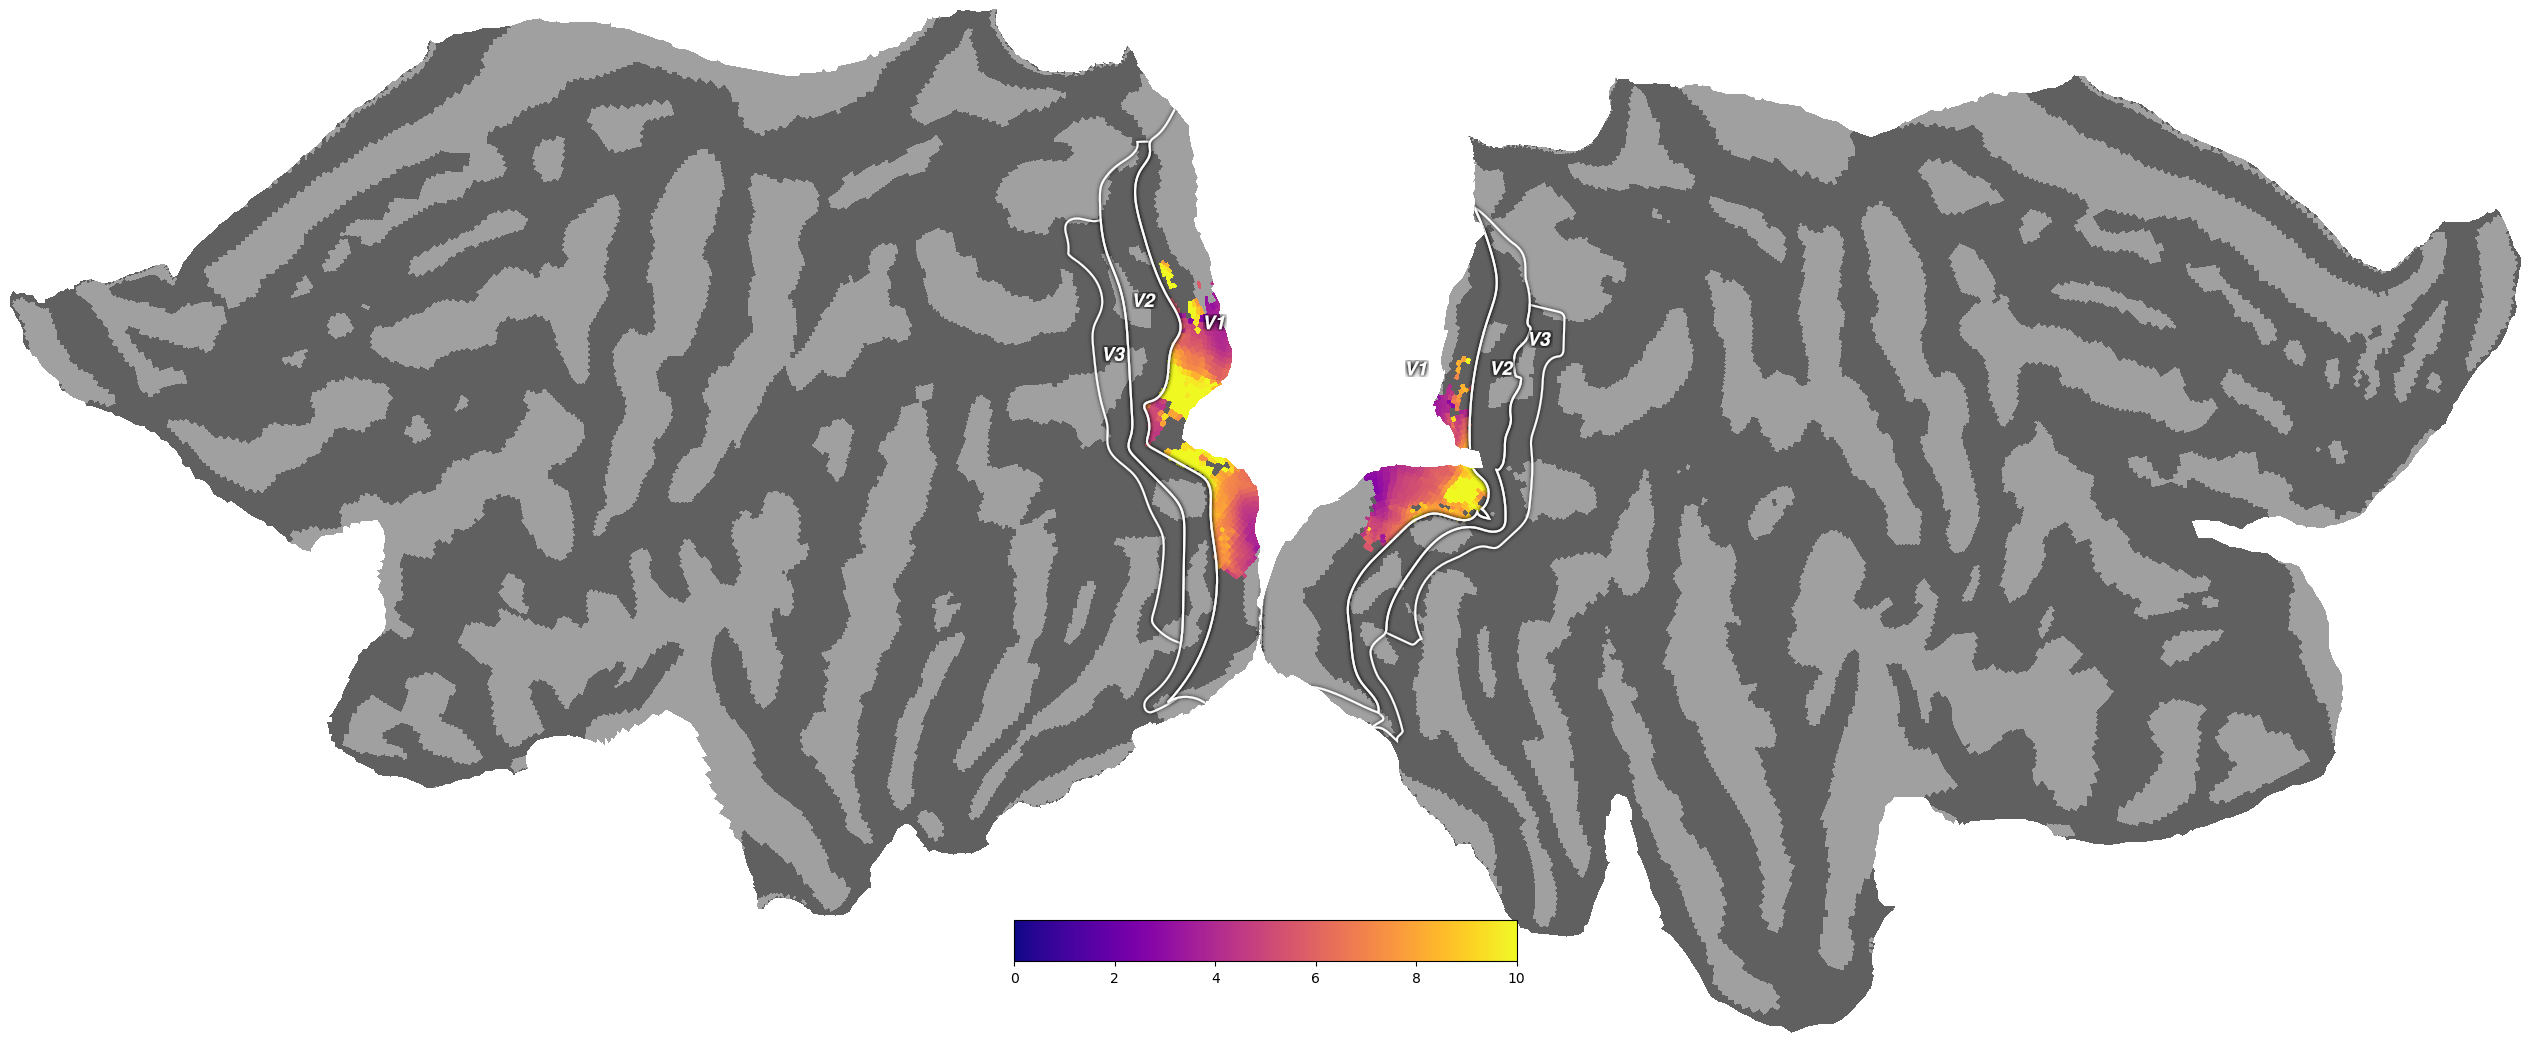

In [94]:
v1mask = myv1surf.intmask.astype(bool)

toplot = np.zeros([myv1surf.intmask.size])
toplot[:] = np.nan
toplot[v1mask] = myv1surf.CMF
cx.quickshow(cx.Vertex(toplot, subject='hcp_999999', cmap='plasma', vmin=0, vmax=10), with_curvature=True)


In [221]:
myv1surf.visual_distance_matrix
# myv1surf.logvisual_distance_matrix

array([[0.        , 0.1867309 , 0.19251213, ..., 3.03863345, 0.87498388,
        8.78891561],
       [0.1867309 , 0.        , 0.15260642, ..., 2.91821435, 0.77660267,
        8.61236016],
       [0.19251213, 0.15260642, 0.        , ..., 3.06444443, 0.92883665,
        8.71309801],
       ...,
       [3.03863345, 2.91821435, 3.06444443, ..., 0.        , 2.16720745,
        6.33038931],
       [0.87498388, 0.77660267, 0.92883665, ..., 2.16720745, 0.        ,
        8.07876231],
       [8.78891561, 8.61236016, 8.71309801, ..., 6.33038931, 8.07876231,
        0.        ]])

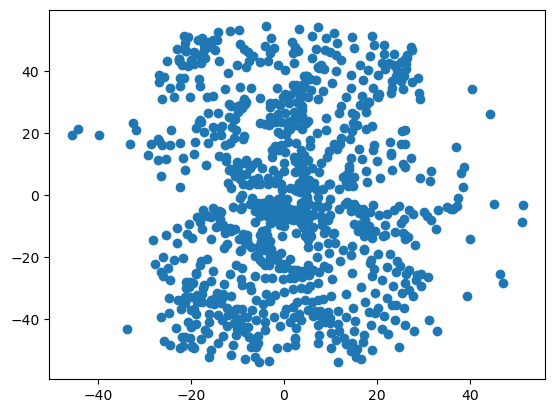

In [482]:
plt.scatter(myv1surf.logxy_verts['logx'], myv1surf.logxy_verts['logy'])

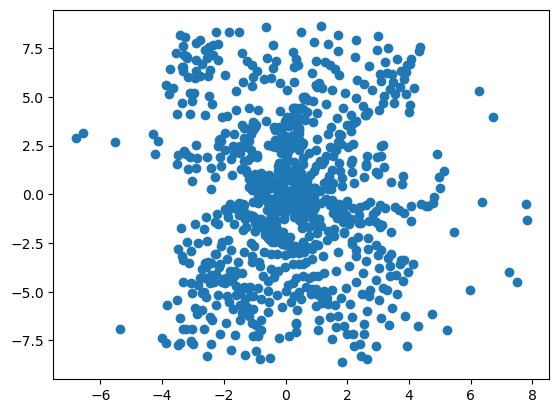

In [483]:
plt.scatter(myv1surf.xy_verts['x'], myv1surf.xy_verts['y'])

In [230]:
sub=2
np.save(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/subsurface_verts_sub-0{sub}_fsnative.npy', myv1surf.subsurface_verts)
np.save(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/distance_matrix_sub-0{sub}_fsnative.npy', myv1surf.distance_matrix)
np.save(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/logvisual_distance_matrix_sub-0{sub}_fsnative.npy', myv1surf.logvisual_distance_matrix)
np.save(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/visual_distance_matrix_sub-0{sub}_fsnative.npy', myv1surf.visual_distance_matrix)

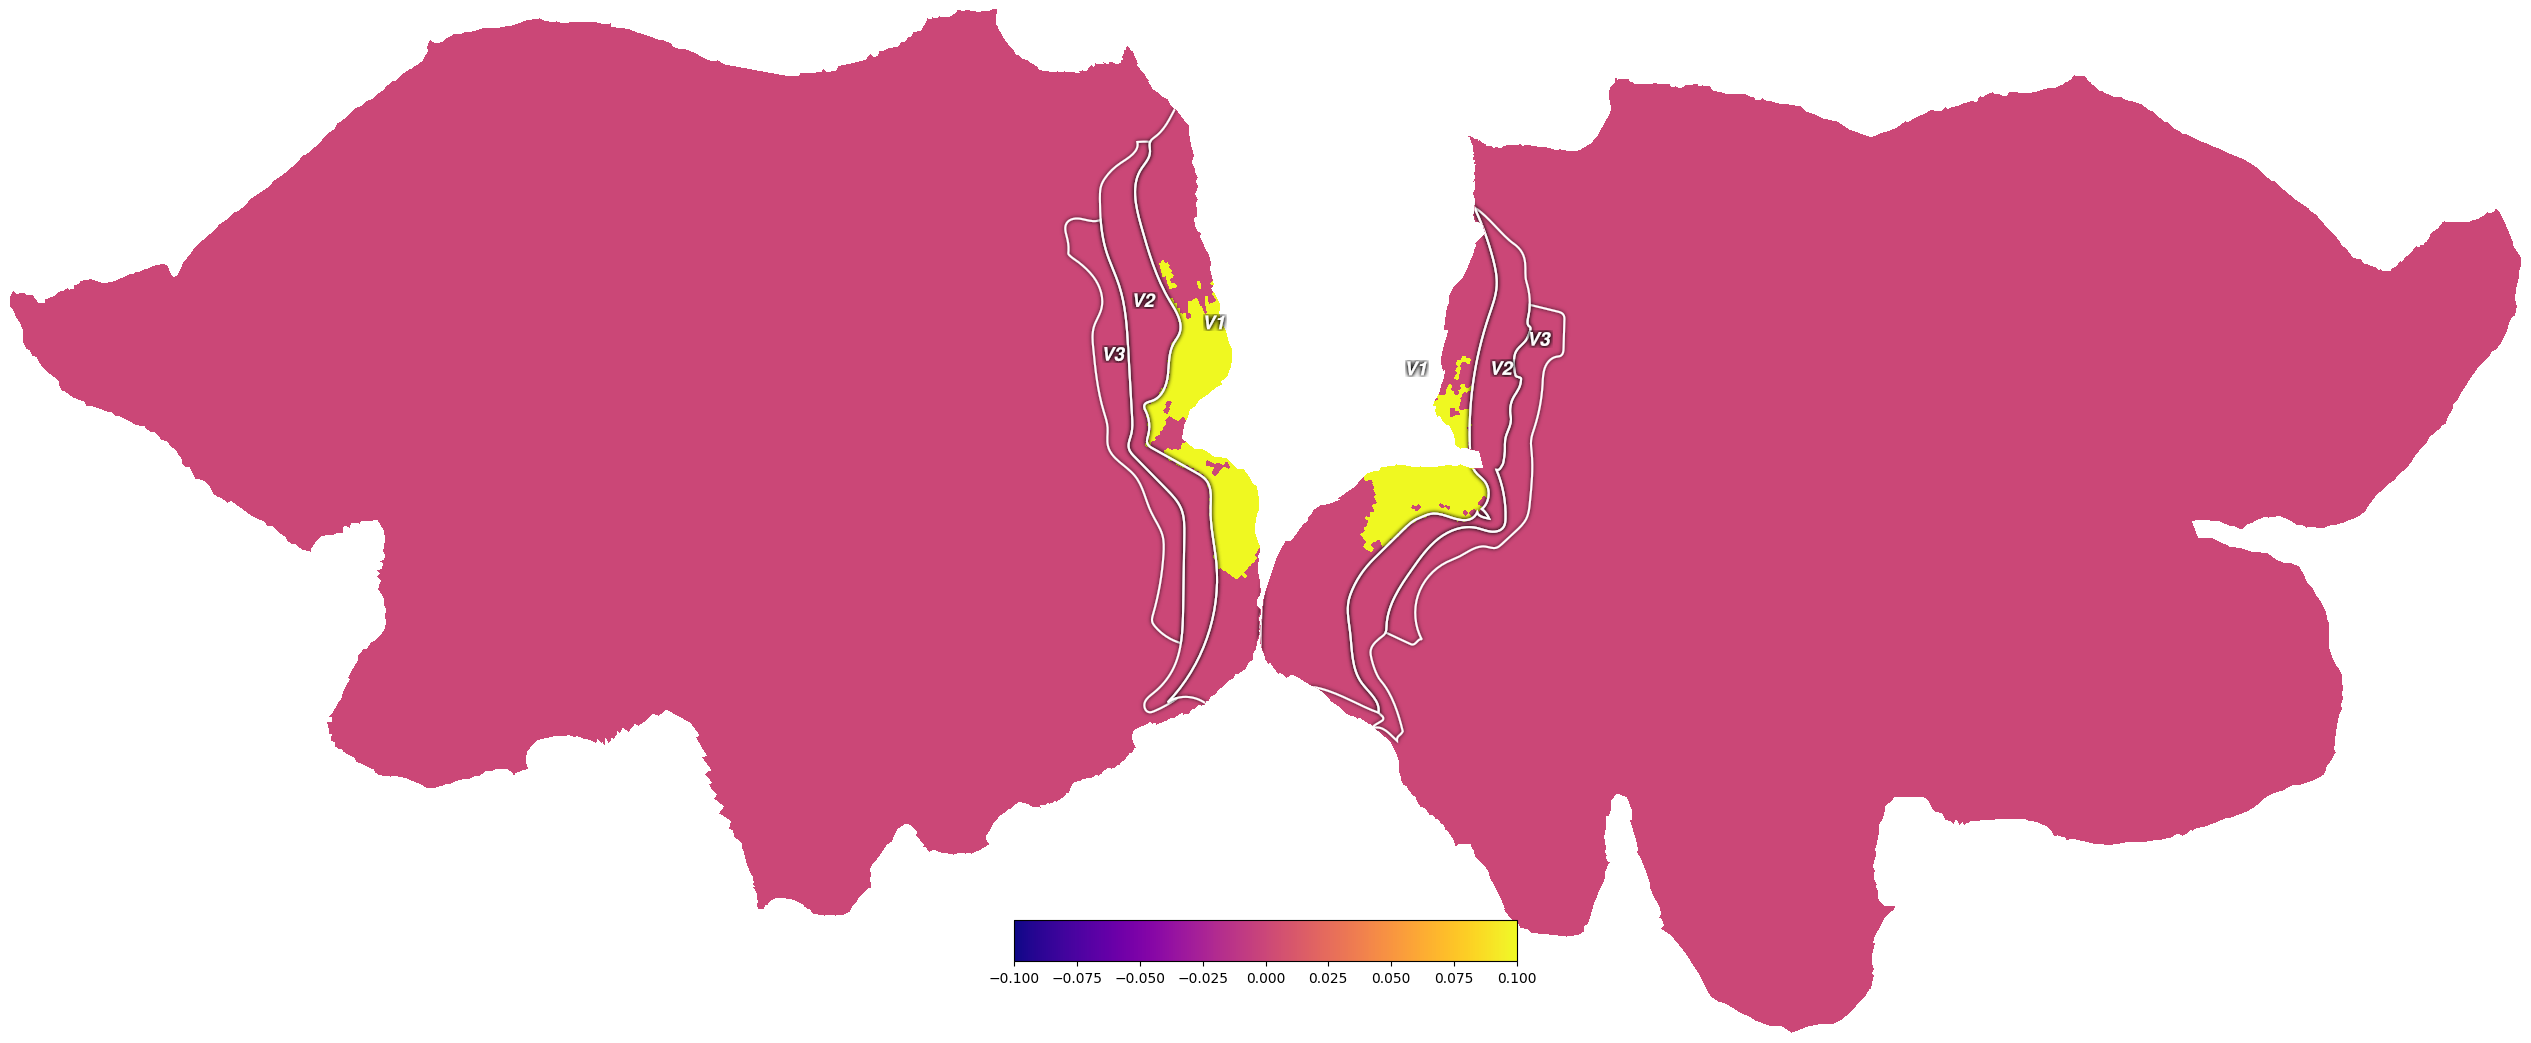

In [9]:
# myv1surf.intmask is a binary mask that shows which vertices we use for CF sampling
cx.quickshow(cx.Vertex(myv1surf.intmask, subject='hcp_999999', cmap='plasma'), with_curvature=True);
